# Privacy-Preserving Record Linkage (PPRL): Investigating Dataset Extension Attacks

## Setup

In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision

from utils import *

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import hickle as hkl
import numpy as np
import string
import sys
from tqdm.notebook import tqdm

from graphMatching.gma import run_gma

from datasets.bloom_filter_dataset import BloomFilterDataset
from datasets.tab_min_hash_dataset import TabMinHashDataset
from datasets.two_step_hash_dataset_padding import TwoStepHashDatasetPadding
from datasets.two_step_hash_dataset_frequency_string import TwoStepHashDatasetFrequencyString

from pytorch_models.bloom_filter_to_two_gram_classifier import BloomFilterToTwoGramClassifier
from pytorch_models.tab_min_hash_to_two_gram_classifier import TabMinHashToTwoGramClassifier
from pytorch_models.two_step_hash_to_two_gram_classifier import TwoStepHashToTwoGramClassifier

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:20:01) [Clang 18.1.8 ]
PyTorch version 2.1.2
Torchvision version 0.16.2
Numpy version 1.24.4
Pandas version 2.0.3


## Run GMA

In [2]:
# Parameters
GLOBAL_CONFIG = {
    "Data": "./data/datasets/fakename_5k.tsv",
    "Overlap": 0.9,
    "DropFrom": "Both",
    "Verbose": True,  # Print Status Messages
    "MatchingMetric": "cosine",
    "Matching": "MinWeight",
    "Workers": -1,
    "SaveAliceEncs": False,
    "SaveEveEncs": False,
    "DevMode": True,
}

DEA_CONFIG = {
    "TSHPadding": True,
    "DevMode": True,
}

ENC_CONFIG = {
    "AliceAlgo": "BloomFilter",
    "AliceSecret": "SuperSecretSalt1337",
    "AliceN": 2,
    "AliceMetric": "dice",
    "EveAlgo": "BloomFilter",
    "EveSecret": "ATotallyDifferentString42",
    "EveN": 2,
    "EveMetric": "dice",
    # For BF encoding
    "AliceBFLength": 1024,
    "AliceBits": 10,
    "AliceDiffuse": False,
    "AliceT": 10,
    "AliceEldLength": 1024,
    "EveBFLength": 1024,
    "EveBits": 10,
    "EveDiffuse": False,
    "EveT": 10,
    "EveEldLength": 1024,
    # For TMH encoding
    "AliceNHash": 1024,
    "AliceNHashBits": 64,
    "AliceNSubKeys": 8,
    "Alice1BitHash": True,
    "EveNHash": 1024,
    "EveNHashBits": 64,
    "EveNSubKeys": 8,
    "Eve1BitHash": True,
    # For 2SH encoding
    "AliceNHashFunc": 10,
    "AliceNHashCol": 1000,
    "AliceRandMode": "PNG",
    "EveNHashFunc": 10,
    "EveNHashCol": 1000,
    "EveRandMode": "PNG",
}

EMB_CONFIG = {
    "Algo": "Node2Vec",
    "AliceQuantile": 0.9,
    "AliceDiscretize": False,
    "AliceDim": 128,
    "AliceContext": 10,
    "AliceNegative": 1,
    "AliceNormalize": True,
    "EveQuantile": 0.9,
    "EveDiscretize": False,
    "EveDim": 128,
    "EveContext": 10,
    "EveNegative": 1,
    "EveNormalize": True,
    # For Node2Vec
    "AliceWalkLen": 100,
    "AliceNWalks": 20,
    "AliceP": 250,
    "AliceQ": 300,
    "AliceEpochs": 5,
    "AliceSeed": 42,
    "EveWalkLen": 100,
    "EveNWalks": 20,
    "EveP": 250,
    "EveQ": 300,
    "EveEpochs": 5,
    "EveSeed": 42
}

ALIGN_CONFIG = {
    "RegWS": max(0.1, GLOBAL_CONFIG["Overlap"]/2), #0005
    "RegInit":1, # For BF 0.25
    "Batchsize": 1, # 1 = 100%
    "LR": 200.0,
    "NIterWS": 100,
    "NIterInit": 5 ,  # 800
    "NEpochWS": 100,
    "LRDecay": 1,
    "Sqrt": True,
    "EarlyStopping": 10,
    "Selection": "None",
    "MaxLoad": None,
    "Wasserstein": True
}

In [3]:
eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash = get_hashes(GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG)

if(os.path.isfile("./data/available_to_eve/reidentified_individuals_%s_%s_%s_%s.tsv" % (eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash)) & os.path.isfile("./data/available_to_eve/not_reidentified_individuals_%s_%s_%s_%s.h5" % (eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash))):
    #Load Disk From Data
    #TODO: Replace pd.read_csv with hkl.load
    reidentified_individuals = pd.read_csv('./data/available_to_eve/reidentified_individuals_%s_%s_%s_%s.tsv' % (eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash), delimiter='\t')
    df_reidentified_individuals = reidentified_individuals

    not_reidentified_individuals = hkl.load('./data/available_to_eve/not_reidentified_individuals_%s_%s_%s_%s.h5' % (eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash))
    df_not_reidentified_individuals = pd.DataFrame(not_reidentified_individuals[1:], columns=not_reidentified_individuals[0])

else:
    reidentified_individuals, not_reidentified_individuals = run_gma(GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG, ALIGN_CONFIG, eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash)

    df_reidentified_individuals = pd.DataFrame(reidentified_individuals[1:], columns=reidentified_individuals[0])
    df_not_reidentified_individuals = pd.DataFrame(not_reidentified_individuals[1:], columns=not_reidentified_individuals[0])

In [4]:
print('Reidentified Individuals:')
print(df_reidentified_individuals.head())
print('Not Reidentified Individuals:')
print(df_not_reidentified_individuals.head())

Reidentified Individuals:
  GivenName    Surname    Birthday  \
0    Glenda     Davila  10/23/1977   
1    Robert      Oates   4/27/1971   
2     Tammy   Humphrey   11/1/1976   
3    Martin  Steinberg    2/9/1962   
4  Clarence    Lombard   2/20/1941   

                                         bloomfilter    uid  
0  0010000000001100011100000000100000000100100010...   9228  
1  1000001000001100000000011110000000100100100010...  14541  
2  0001011010001001100000100000100110000010100000...  80251  
3  0000110001100000010000010100000100101000100000...  62614  
4  1000010010000100010100000000000110000100100010...  49239  
Not Reidentified Individuals:
                                         bloomfilter    uid
0  0001010000000000010100000110100010101010110000...  45832
1  0000111011100000000100000000100110000000100000...  78181
2  0001000010101001000000000011100000001000110010...  29666
3  1001000000001000000001010010000000000100100010...  20797
4  0010000001000001010100111000100000000100

## Create Datasets 

In [5]:
#Create the 2-grams with dictionary

#Generate all 2-grams
alphabet = string.ascii_lowercase

# Generate all letter-letter 2-grams (aa-zz)
alphabet = string.ascii_lowercase
letter_letter_grams = [a + b for a in alphabet for b in alphabet]

# Generate all digit-digit 2-grams (00-99)
digits = string.digits
digit_digit_grams = [d1 + d2 for d1 in digits for d2 in digits]

# Generate all letter-digit 2-grams (a0-z9)
letter_digit_grams = [l + d for l in alphabet for d in digits]

# Combine all sets
all_two_grams = letter_letter_grams  + letter_digit_grams + digit_digit_grams

# Get a dictionary associating each 2-gram with an index
two_gram_dict = {i: two_gram for i, two_gram in enumerate(all_two_grams)}

In [6]:
# Create Datasets based on chosen encoding
if ENC_CONFIG["AliceAlgo"] == "BloomFilter":
    data_labeled = BloomFilterDataset(df_reidentified_individuals, isLabeled=True, all_two_grams=all_two_grams, dev_mode=GLOBAL_CONFIG["DevMode"])
    data_not_labeled = BloomFilterDataset(df_not_reidentified_individuals, isLabeled=False, all_two_grams=all_two_grams, dev_mode=GLOBAL_CONFIG["DevMode"])
    bloomfilter_length = len(df_reidentified_individuals["bloomfilter"][0])

if ENC_CONFIG["AliceAlgo"] == "TabMinHash":
    data_labeled = TabMinHashDataset(df_reidentified_individuals, isLabeled=True, all_two_grams=all_two_grams, dev_mode=GLOBAL_CONFIG["DevMode"])
    data_not_labeled = TabMinHashDataset(df_not_reidentified_individuals, isLabeled=False, all_two_grams=all_two_grams, dev_mode=GLOBAL_CONFIG["DevMode"])
    tabminhash_length = len(data_labeled[0][0])

if (ENC_CONFIG["AliceAlgo"] == "TwoStepHash") & DEA_CONFIG["TSHPadding"]:
    max_length_reidentified = df_reidentified_individuals["twostephash"].apply(lambda x: len(list(x))).max()
    max_length_not_reidentified = df_not_reidentified_individuals["twostephash"].apply(lambda x: len(list(x))).max()
    max_twostephash_length = max(max_length_reidentified, max_length_not_reidentified)
    data_labeled = TwoStepHashDatasetPadding(df_reidentified_individuals, isLabeled=True, all_two_grams=all_two_grams, max_set_size=max_twostephash_length, dev_mode=GLOBAL_CONFIG["DevMode"])
    data_not_labeled = TwoStepHashDatasetPadding(df_not_reidentified_individuals, isLabeled=False, all_two_grams=all_two_grams, max_set_size=max_twostephash_length, dev_mode=GLOBAL_CONFIG["DevMode"])

if (ENC_CONFIG["AliceAlgo"] == "TwoStepHash") &  (not DEA_CONFIG["TSHPadding"]):
    max_length_reidentified = df_reidentified_individuals["twostephash"].apply(lambda x: max(x)).max()
    max_length_not_reidentified = df_not_reidentified_individuals["twostephash"].apply(lambda x: max(x)).max()
    max_twostephash_length = max(max_length_reidentified, max_length_not_reidentified)
    data_labeled = TwoStepHashDatasetFrequencyString(df_reidentified_individuals, isLabeled=True, all_two_grams=all_two_grams, frequency_string_length=max_twostephash_length, dev_mode=GLOBAL_CONFIG["DevMode"])
    data_not_labeled = TwoStepHashDatasetFrequencyString(df_not_reidentified_individuals, isLabeled=False, all_two_grams=all_two_grams, max_length=max_twostephash_length, dev_mode=GLOBAL_CONFIG["DevMode"])

## Create Dataloader

In [7]:
# Split proportions
train_size = int(0.8 * len(data_labeled))  # 80% training
val_size = len(data_labeled) - train_size  # 20% validation

#Split dataset of reidentified individuals
data_train, data_val = random_split(data_labeled, [train_size, val_size])

In [8]:
# Create dataloader
dataloader_train = DataLoader(data_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=32, shuffle=True)
dataloader_test = DataLoader(data_not_labeled, batch_size=32, shuffle=False)

## Pytorch Model

In [9]:
# Create Models based on chosen encoding scheme
if ENC_CONFIG["AliceAlgo"] == "BloomFilter":
    model = BloomFilterToTwoGramClassifier(input_dim=bloomfilter_length, num_two_grams=len(all_two_grams))

if ENC_CONFIG["AliceAlgo"] == "TabMinHash":
    model = TabMinHashToTwoGramClassifier(input_dim=tabminhash_length, num_two_grams=len(all_two_grams))

if (ENC_CONFIG["AliceAlgo"] == "TwoStepHash") & DEA_CONFIG["TSHPadding"]:
    model = TwoStepHashToTwoGramClassifier(input_dim=max_twostephash_length, num_two_grams=len(all_two_grams))

if (ENC_CONFIG["AliceAlgo"] == "TwoStepHash") & (not DEA_CONFIG["TSHPadding"]):
    model = TabMinHashToTwoGramClassifier(input_dim=tabminhash_length, num_two_grams=len(all_two_grams))


## Training Loop

In [10]:
# Setup

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Number of epochs
num_epochs = 15
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for data, labels in tqdm(dataloader_train, desc="Training loop"):
        # Move data to device
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(dataloader_train.dataset)
    train_losses.append(train_loss)

    #Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data, labels in tqdm(dataloader_val, desc="Validation loop"):
            # Move data to device
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
        val_loss = running_loss / len(dataloader_val.dataset)
        val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1/15 - Train loss: 0.1020, Validation loss: 0.0638


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2/15 - Train loss: 0.0630, Validation loss: 0.0589


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3/15 - Train loss: 0.0555, Validation loss: 0.0498


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4/15 - Train loss: 0.0466, Validation loss: 0.0421


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5/15 - Train loss: 0.0394, Validation loss: 0.0362


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6/15 - Train loss: 0.0339, Validation loss: 0.0324


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7/15 - Train loss: 0.0297, Validation loss: 0.0293


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8/15 - Train loss: 0.0262, Validation loss: 0.0269


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9/15 - Train loss: 0.0234, Validation loss: 0.0251


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10/15 - Train loss: 0.0212, Validation loss: 0.0236


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11/15 - Train loss: 0.0192, Validation loss: 0.0227


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12/15 - Train loss: 0.0175, Validation loss: 0.0220


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13/15 - Train loss: 0.0162, Validation loss: 0.0212


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14/15 - Train loss: 0.0150, Validation loss: 0.0204


Training loop:   0%|          | 0/103 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15/15 - Train loss: 0.0140, Validation loss: 0.0202


## Visualize Losses and Performance Metrics

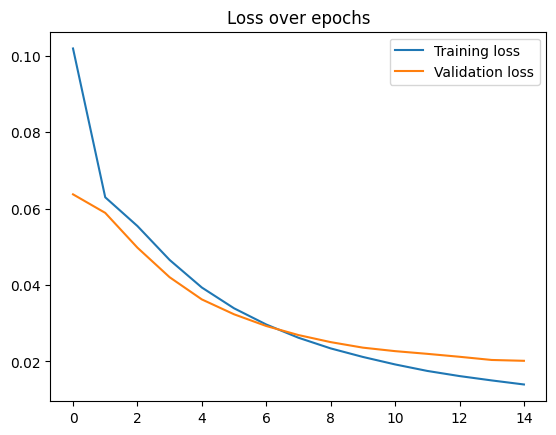

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Re-Identify Not-Reidentified Individuals

## Visualize Performance for Re-Identification

## Testing Area

In [ ]:
# First entry for reference (labeled data):
# surname                                                  Hegarty
# firstname                                    Miss. Hanora "Nora"
# bloomfilter    0000000010100011000100000101000000000000100000001000000000100111011000001001100100000100000000001000000000000000001000100000000000010010000000000000100010001110110111000000000000100000000100000001010000000000100101000011000010001010000001000000000000000000001000011010011001000100000011100100000000000011000100100000110011000000000010000000000010000000000000110000000110000000000010000000011100000001000000100000001100101011001000000000010000001000000000001000010110110000000001001000100001010111010000000010000000111000000000010010110000000000001000000101010001000000001000001000010000100110000111001110000000001010011110000100000000000100000001100001100000000000010000000000000000000000100000000010000001000000000011100000000000001000101000010100001001000011000000000010001100000000100000001000001000000000100000101000000000000000000010000000100000000100001000000100000000000000011100000001001000000001100010000001000001000000000000010100100000000110101110010000010000010100000000011000001000000001110000101001000010101111
# uid                                                          654
# Name: 0, dtype: object
#print('Length Labeled data:', len(data_labeled))
#print('Length Unlabeled data:', len(data_not_labeled))

#bloomfilter_tensor, label_tensor = data_labeled[0]

#print('Bloom Filter Tensor:', bloomfilter_tensor)
#print('Bloom Filter Tensor Shape:', bloomfilter_tensor.shape)
#print('Label Tensor:', label_tensor)
#print('Label Tensor Shape:', label_tensor.shape)

#for bloomfilter_tensors, label_tensors in dataloader_train:
#    print('Bloom Filter Tensor Shape:', bloomfilter_tensors.shape)
#    print('Label Tensor Shape:', label_tensors.shape)
#    print(label_tensors)
#    break

#print(str(model)[:500])
#example_bloom, example_label = data_train[0]
#example_out = model(example_bloom)
#print(example_out.shape)
#loss_function_applied = criterion(example_out, example_label)
#print(loss_function_applied)
#print(example_out)

print(data_labeled[0])

# Apply model
result = model(bloomfilter_tensor)
# Result = Tensor of shape 676 with prob. for each 2gram
two_gram_scores = {two_gram_dict[i]: score.item() for i, score in enumerate(result)}

threshold = 0.000000001
filtered_two_gram_scores = {two_gram: score for two_gram, score in two_gram_scores.items() if score > threshold}
filtered_two_gram_scores

In [16]:
print("To Decode: ",df_not_reidentified_individuals.iloc[1])
torch.set_printoptions(profile="full")
#torch.set_printoptions(profile="default")
print("BF Tensor: ", data_not_labeled[1])
# Apply model
model.eval()
logits = model(data_not_labeled[1])
probabilities = torch.sigmoid(logits)
print("Prob: ", probabilities)
two_gram_scores = {two_gram_dict[i]: score.item() for i, score in enumerate(probabilities)}
threshold = 0.1
filtered_two_gram_scores = {two_gram: score for two_gram, score in two_gram_scores.items() if score > threshold}
print("Decoded 2grams: ", filtered_two_gram_scores)

# person is: Michael	Schley	1/9/1962

To Decode:  bloomfilter    0000111011100000000100000000100110000000100000...
uid                                                        78181
label                                                         []
Name: 1, dtype: object
BF Tensor:  tensor([0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.

In [21]:
for bloom_filters, labels in dataloader_train:
    print("Bloom Filters Batch Shape:", bloom_filters.shape)
    print("Labels Batch Shape:", labels.shape)
    print(bloom_filters[0])
    break

Bloom Filters Batch Shape: torch.Size([32, 1024])
Labels Batch Shape: torch.Size([32, 1036])
tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [ ]:
model = nn.Linear(20, 5) # predict logits for 5 classes
x = torch.randn(1, 20)
print(x.shape)
y = torch.tensor([[1., 0., 1., 0., 0.]]) # get classA and classC as active
print(y.shape)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

for epoch in range(20):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    print('Loss: {:.3f}'.format(loss.item()))

In [ ]:
for bloom_filters, labels in dataloader_train:
    print("Bloom Filters Batch Shape:", bloom_filters[0])
    print("Labels Batch Shape:", labels[0])
    break

In [12]:
len(data_labeled)

4090